## Reproduce solvent segregation in Wang 2022 - Fig. 4
### $ D_{\text{e},\text{EC}}^0 = 0, \, 1.5 \times 10^{-11}  \ \text{m}^2/\text{s} $ for 1M LiPF6 in EMC:EC 1:1 wt%

In [42]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = os.path.expanduser("~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/")
Target  = 'Reproduce_Sol_Seg_240318_Fun_Xi_tidle/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)
Save_Fig = True

In [44]:
# define parameter of double and single 
Para_dict_Same = {
   "Mesh list":[ [20,10,20,80,20], ],   # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   "Contact resistance [Ohm]":[12e-3],
   "Initial Neg SOC":[0.8841301667966484,],
   "Initial Pos SOC":[0.23552755074598045,],}
Para_dict_DD_ONLY = {
   "Model option":[{
      "SEI": "constant",
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "double spatial consume w refill",
      "electrolyte conductivity": "sol full"  ,
     "contact resistance":"true",  },],
   "Lithium ion EC cross diffusivity [m2.s-1]":[1e-11,], # 
   "EC transference number":["Fun_Xi_tidle"],
}
Para_dict_SD_ONLY = {
   "Model option":[{
      "SEI": "constant",
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "single no consume wo refill",
      "electrolyte conductivity": "full"  ,
      "contact resistance":"true",  },],
   "Lithium ion EC cross diffusivity [m2.s-1]":[0,], #  
   "Measured dLJP_dce":["dLJP_1_Specie_dc_e_np",]
}
Para_dict_DD = {**Para_dict_Same,**Para_dict_DD_ONLY}
Para_dict_SD = {**Para_dict_Same,**Para_dict_SD_ONLY}
Para_DD = [];  Para_SD=[];
recursive_scan(Para_DD,Para_dict_DD, list(Para_dict_DD.keys()), {})
recursive_scan(Para_SD,Para_dict_SD, list(Para_dict_SD.keys()), {})
print(len(Para_DD),len(Para_SD))

1 1


##### 2.5e-11 + 2.5C finish within 16min!

In [45]:
##### Initialise Para_0 and model
def RunOne(Para_dd_i,Rate_Dis):
    CyclePack,para_used = Para_init_Dict(Para_dd_i)
    [Mesh_list,model_options] = CyclePack
    model = pybamm.lithium_ion.DFN(options=model_options)
    str_model_options = str(model_options)
    V_max = 4.2;        V_min = 2.5; #Rate_Dis = 3
    if Rate_Dis > 1:
        ts_dis = 0.5
    else: 
        ts_dis = 1
    Exp_1  = pybamm.Experiment(
    [ (
        f"Hold at {V_max} V until C/100",
        f"Discharge at {Rate_Dis} C until {V_min} V ({ts_dis} second period)", 
        )    ] * 1 )  
    model = Add_var(para_used,model) # add extra variable to model
    var_pts = {
        "x_n": Mesh_list[0],  # negative electrode
        "x_s": Mesh_list[1],  # separator 
        "x_p": Mesh_list[2],  # positive electrode
        "r_n": Mesh_list[3],  # negative particle
        "r_p": Mesh_list[4],  # positive particle
    }
    sim    = pybamm.Simulation(
        model, experiment = Exp_1,
        parameter_values = para_used,
        solver = pybamm.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts,
        )       
    sol    = sim.solve()
    return sol
# D_e,EC=1e-11, 1C finish in 1min; 1.5C - finish 1min;  1.9C-24min
#     2C - cannot finish in 1h,
Sol_DD = []; Rate_Dis = 1
for i in range(len(Para_DD)):   
    Sol_DD.append(RunOne(Para_DD[i],Rate_Dis=Rate_Dis)) 
    para = Para_DD[i]
    print("D_e,EC=",para["Lithium ion EC cross diffusivity [m2.s-1]"])


D_e,EC= 1e-11


CyclePack,para_used = Para_init_Dict(Para_DD[i])
[Mesh_list,model_options] = CyclePack
model = pybamm.lithium_ion.DFN(options=model_options)
dLJP_dcEC = para_used["Measured dLJP_dcEC"]
dLJP_dce  = para_used["Measured dLJP_dce"]   # (c_e,c_EC,T)

CyclePack,para_used = Para_init_Dict(Para_SD[i])
dLJP_dce_SD  = para_used["Measured dLJP_dce"]   # (c_e,c_EC,T)
print("dLJP_dce")
print(dLJP_dce_SD(1500,6209.49,298.15))
print(dLJP_dce   (1500,6209.49,298.15))

print(dLJP_dcEC(1500,6000,298.15))

Sol_DD[0]["Cell temperature [K]"].entries

In [46]:
""" Sol_SD = []
for i in range(len(Para_SD)):
    Sol_SD.append(RunOne(Para_SD[i],Rate_Dis=2.8)) 
    para = Para_SD[i]
    #print("D_EC=",para["EC diffusivity in electrolyte [m2.s-1]"])
    print("D_e,EC=",para["Lithium ion EC cross diffusivity [m2.s-1]"]) """

' Sol_SD = []\nfor i in range(len(Para_SD)):\n    Sol_SD.append(RunOne(Para_SD[i],Rate_Dis=2.8)) \n    para = Para_SD[i]\n    #print("D_EC=",para["EC diffusivity in electrolyte [m2.s-1]"])\n    print("D_e,EC=",para["Lithium ion EC cross diffusivity [m2.s-1]"]) '

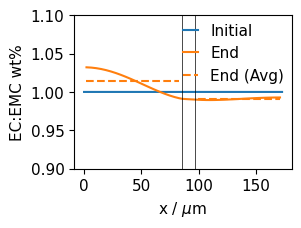

In [47]:
fs = 11; font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
Labels = ["0.6 M","1.0 M","1.6 M"]

def Plot_Sol_Seg(sol,Rate_Dis,Ylim,Save_Fig,fig_name):
    step_i  =sol.cycles[0].steps[1]
    Y_0p = np.arange(-1,10,0.1); X_0 = np.arange(0,172.8,0.1)
    fig, axs = plt.subplots( figsize=(8/2.54,6.14/2.54), tight_layout=True) #
    y_ini = step_i["EC:EMC wt%"].entries[:,0]
    axs.plot( X_0,  np.mean(y_ini[0:20])*np.ones_like(X_0),  Colors[0],label="Initial")
    t_i = (step_i['Time [s]'].entries-step_i['Time [s]'].entries[0]).tolist()
    x =   step_i["x [m]"].entries[:,0]
    x_n =   step_i["x_n [m]"].entries[:,0]
    x_s =   step_i["x_p [m]"].entries[:,0]
    y =   step_i["EC:EMC wt%"].entries[:,-1]
    y_neg = np.mean(y[0:20]);
    y_pos = np.mean(y[-20:]);
    axs.plot(x*1e6,y,color=Colors[1],label="End") 
    axs.plot(
        x_n*1e6,y_neg* np.ones_like(x_n),
        color=Colors[1],linestyle="--",label="End (Avg)") 
    axs.plot(
        x_s*1e6,y_pos* np.ones_like(x_s),
        color=Colors[1],linestyle="--",) 
    axs.set_xlabel(r"x / $\mu$m",fontdict={'family':'DejaVu Sans','size':fs})
    #axs.set_title(Title_keys[i]) 
    axs.ticklabel_format( 
        axis='x', style='sci',
        scilimits=[-1e3,1e3], useOffset=None, 
        useLocale=None, useMathText=None)

    axs.set_ylabel("EC:EMC wt%")
    axs.plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
    axs.plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)
    axs.legend(
        prop={'family':'DejaVu Sans','size':fs},
        markerscale=0.5,borderpad=0.0,
        handlelength=1.0,loc='best',frameon=False)  
    axs.set_ylim(Ylim)
    # fig.suptitle(f"3C Discharge, t={round(t_select)} s", fontsize=fs+1)

    if Save_Fig == True:
        plt.savefig(BasicPath +  Target+ f"{fig_name}.png", dpi=600)
        plt.savefig(BasicPath +  Target+ f"{fig_name}.svg")   
    return
Ylim = (0.9,1.1)
for i in range(len(Para_DD)):
    D_e_EC_cross = Para_DD[i]["Lithium ion EC cross diffusivity [m2.s-1]"]
    Plot_Sol_Seg(
        Sol_DD[i],Rate_Dis,Ylim,Save_Fig,
        fig_name=f"{Rate_Dis}C_1M_EC_EMC_wt%_D_e_EC_cross={D_e_EC_cross}") 



In [48]:
# Plot electrolyte properties plus concentration 
font = {'family' : 'DejaVu Sans','size'   : 13}
mpl.rc('font', **font)
label = ["De,EC=0","De,EC=2.5e-13","De,EC=2.5e-12","Single"] 
var = [
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    "c(EMC) [mol.m-3]",
    "Total electrolyte concentration [mol.m-3]",

    "EC Lithium ion cross diffusivity [m2.s-1]",

    "Electrolyte conductivity [S.m-1]",
    "dLJP_dcEC",
    "dLJP_dce",

    "Battery voltage [V]",
]
quick_plot = pybamm.QuickPlot(
    [
        Sol_DD[0], # Sol_DD[1],Sol_DD[2],Sol_SD[0],
        ], var,variable_limits='tight',    # label,
    time_unit='hours',n_rows=4) #figsize = (18,12),
quick_plot.dynamic_plot()
#quick_plot.plot(0.19)

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9115792038657591, step=0.00911579203865759…

In [49]:
font = {'family' : 'DejaVu Sans','size'   : 15}
mpl.rc('font', **font)

In [50]:
# Plot all kinds of potential 
label = ["0","2.5e-13","2.5e-12","Single"] 
var = [
    "Battery voltage [V]",
    "X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    "X-averaged EC concentration overpotential [V]", # Mark Ruihe add
    "X-averaged battery electrolyte ohmic losses [V]",
    "X-averaged battery solid phase ohmic losses [V]",
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
]
quick_plot = pybamm.QuickPlot(
    [
        Sol_DD[0], # Sol_DD[1],Sol_DD[2],Sol_SD[0],
        ], var,variable_limits='tight',
    time_unit='hours',n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()
#quick_plot.plot(0.14)

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9115792038657591, step=0.00911579203865759…

In [51]:
print(0.15*np.array([9778 , 1.4631, 0.3589]))
1- 2.19465e-01

[1.46670e+03 2.19465e-01 5.38350e-02]


0.780535